### PMIP4 analysis and producing figures for EOS 440 final project 

#### Intake data and filter activity, experiment, variable

In [1]:
# imports should run with given env

import intake
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
# import esm data from server

import intake_esm
url ="https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"

In [3]:
# intake data as xarray

cat = intake.open_esm_datastore(url)

Activity ID for PMIP4 -- experiments used. Lig127k and MidHolocene are taken as the two interglacial datasets, comapred to eachother and the present day Past1000 data.

In [4]:
# filter to PMIP and show experiments 

cat_pmip = cat.search(activity_id = 'PMIP')
cat_pmip.df['experiment_id'].unique()

array(['midHolocene', 'lig127k', 'lgm', 'past1000'], dtype=object)

In [5]:
# seperate each experiemnt out

cat_holo = cat_pmip.search(experiment_id = 'midHolocene', variable_id = 'pr')
cat_lig = cat_pmip.search(experiment_id = 'lig127k', variable_id = 'pr')
cat_now = cat_pmip.search(experiment_id = 'past1000', variable_id = 'pr')

In [6]:
# check the ensemble member numbers for each dataset in order to understand limitations of comparison

print(cat_holo.df['member_id'].unique())
print(cat_lig.df['member_id'].unique())
print(cat_now.df['member_id'].unique())

['r1i1p1f2' 'r1i1p1f3' 'r1i1p1f1']
['r1i1p1f1']
['r1i1p1f1' 'r1i1p1f2']


*Based on the above, we have limited ensemble members for comparison, and need to keep this in mind when discussing results*

#### Convert to dictionary dataset to begin plotting

In [7]:
dset_holo = cat_holo.to_dataset_dict(
    xarray_open_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True}
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [8]:
dset_lig = cat_lig.to_dataset_dict(
    xarray_open_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True}
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [9]:
dset_now = cat_now.to_dataset_dict(
    xarray_open_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True}
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [10]:
# option to un-comment (one at a time) and inspect parameters:

#dset_holo
#dset_lig
#dset_now

In [11]:
# extracting dataset to be usable

ds_holo = dset_holo['PMIP.IPSL.IPSL-CM6A-LR.midHolocene.Amon.gr']
ds_lig = dset_lig['PMIP.IPSL.IPSL-CM6A-LR.lig127k.Amon.gr']
ds_now = dset_now['PMIP.MRI.MRI-ESM2-0.past1000.Amon.gn']


In [12]:
# function to convert precipitation variable into mm/h

def convert_kg_m2s_to_mm_h(pr_kg_m2s):
    """
    Convert precipitation from kg/m²/s to mm/h.
    
    Parameters:
    pr_kg_m2s (xarray.DataArray or numpy array): precipitation in kg/m²/s
    
    Returns:
    xarray.DataArray or numpy array: Precipitation in mm/h
    """
    return pr_kg_m2s * 3600

In [13]:
# resample each dataset to be in seasons instead of per month

rs_holo = ds_holo.pr.resample(time='QS-DEC').mean(dim='time') # extract pr variable 
rs_lig = ds_lig.pr.resample(time='QS-DEC').mean(dim='time')
rs_now = ds_now.pr.resample(time='QS-DEC').mean(dim='time')

In [14]:
# definition for creating world map plots

def plot_precipitation(dataset, levels, title):
    """
    Plot precipitation data on a world map using the PlateCarree projection.
    
    Parameters:
    dataset (xarray.DataArray): Precipitation dataset to plot
    levels (array): Contour levels for precipitation
    title (str): Title of the plot
    """
    plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    dataset.plot.pcolormesh(ax=ax, cmap='coolwarm', transform=ccrs.PlateCarree(), levels=levels)
    
    ax.coastlines()
    ax.set_title(title)
    
    plt.show()

In [34]:
# rs_holo has other dimensions member_id: 3, dcpp_init_year: 1, so for the preliminary plots we average these too
# select last 200 time steps (i.e., last 50 years)
def time_series_global_precip(dataset, start_year):
    
    last50 = dataset.isel(time=slice(start_year, None), dcpp_init_year=0).mean(dim='member_id')
    
    # Compute global average (assuming 'lat' and 'lon' are coordinate names)
    global_avg = last50.mean(dim=['lat', 'lon'])
    
    ga_mmh = convert_kg_m2s_to_mm_h(global_avg)
    
    return ga_mmh




def plot_timeseries(title, dataset, color, ax=None):

    if ax==None:
        fig, ax = plt.subplots(figsize=(12, 5))  # Wider plot
    dataset.plot(ax=ax, color=color, linewidth=2)
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Time", fontsize=12)
    ax.set_ylabel("Precipitation (mm/h)", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()
    return ax


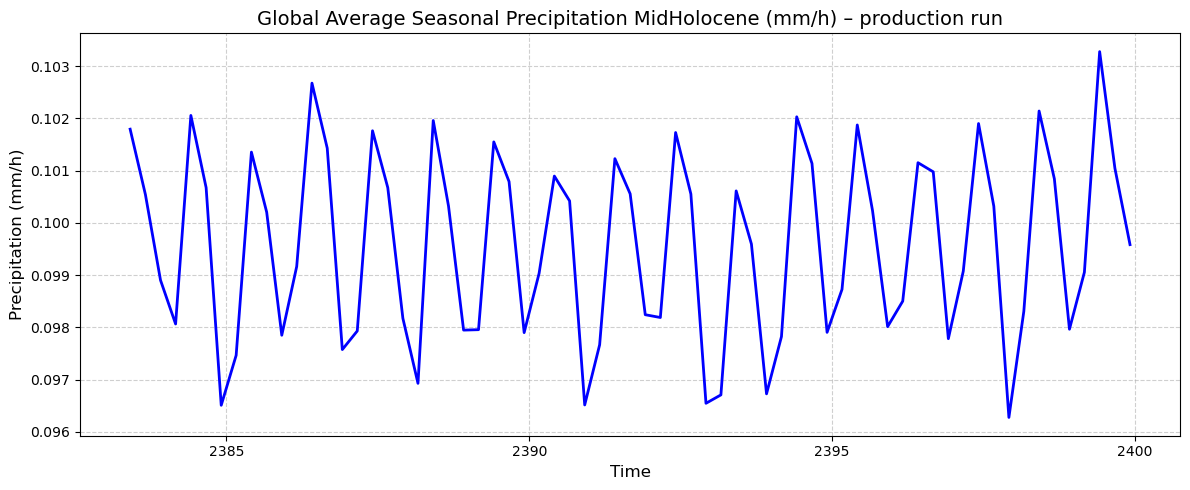

<Figure size 640x480 with 0 Axes>

In [40]:
holo_ts_seasonal = time_series_global_precip(rs_holo, -67)
ax1 = plot_timeseries('Global Average Seasonal Precipitation MidHolocene (mm/h) – production run', holo_ts_seasonal, 'blue')
holo_ts_monthly = time_series_global_precip(ds_holo.pr, -200)
ax = plot_timeseries('Global Average Seasonal Precipitation MidHolocene (mm/h) – production run', holo_ts_monthly, 'orange', ax=ax1)


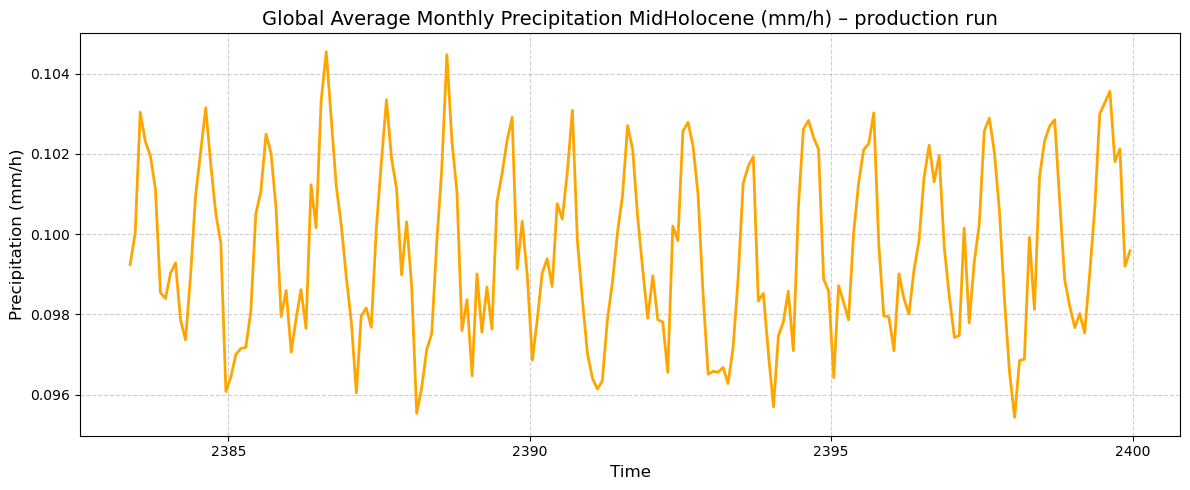

('Global Average Monthly Precipitation MidHolocene (mm/h) – production run',)

In [39]:
holo_monthly = time_series_global_precip(ds_holo.pr, -200)
plot_timeseries('Global Average Monthly Precipitation MidHolocene (mm/h) – production run', holo_monthly, 'orange', ax=None)

'Global Average Monthly Precipitation MidHolocene (mm/h) – production run',

In [ ]:
#time_series_global_precip(rs_lig, 'Global Average Precipitation Last Interglacial (mm/h) – production run')

In [ ]:
#time_series_global_precip(rs_now, 'Global Average Precipitation Pre 1850 (recent) (mm/h) – production run')

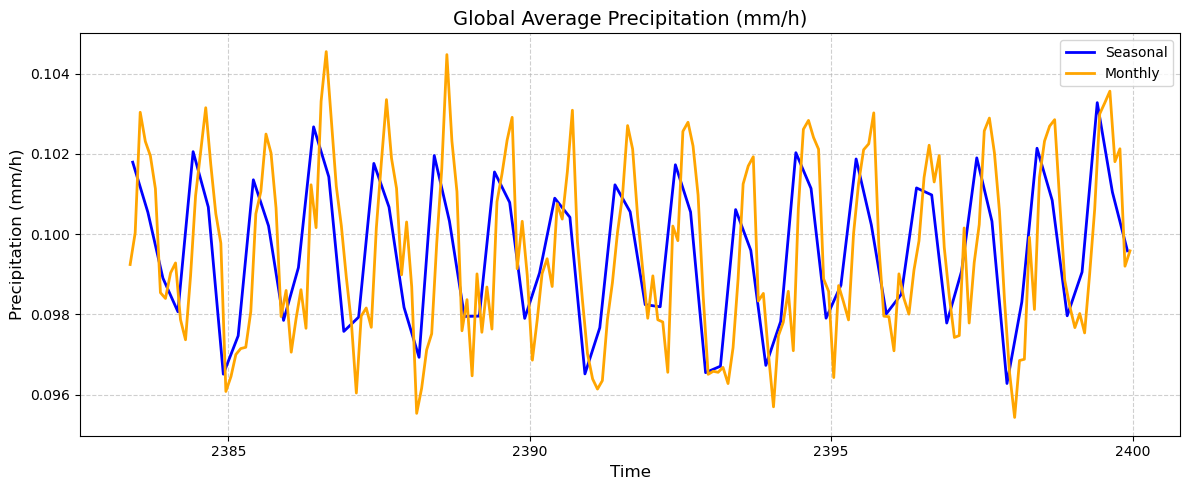

In [41]:
fig, ax = plt.subplots(figsize=(12, 5))

holo_ts_seasonal.plot(ax=ax, color='blue', label='Seasonal', linewidth=2)
holo_ts_monthly.plot(ax=ax, color='orange', label='Monthly', linewidth=2)

ax.set_title("Global Average Precipitation (mm/h)", fontsize=14)
ax.set_xlabel("Time", fontsize=12)
ax.set_ylabel("Precipitation (mm/h)", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()
